In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
tf.set_random_seed(2)
config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

# LOAD KERAS PRETRAINED MODEL

In [4]:
from keras.models import load_model

model = load_model('finetune.model')
model.load_weights('weights.best.hdf5')

print(model.summary())




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_________________________________________________________________________________________

# LOAD AND PREPROCESS IMAGE

In [5]:
from PIL import Image, ImageDraw
from keras_preprocessing.image import img_to_array

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
def preprocess_input_inceptionv3(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [7]:
def load_image(path): 
  img = Image.open(path)
  img = np.array(img)
  x = img_to_array(img)
  x = preprocess_input_inceptionv3(x)

  return x

In [8]:
class_names = {
    0: '1886 - Accessories', 
    1: '1887 - Swimwear', 
    2: '1888 - Dresses',
    3: '1889 - Upper part', 
    4: '1890 - Shoes', 
    5: '1891 - Bottom part', 
    6: '1892 - Underwear'
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


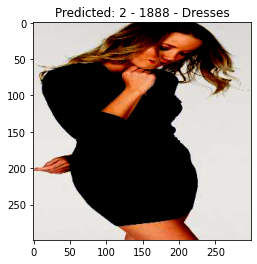

In [9]:
from os import listdir
from os.path import isfile, join

x = load_image('images/1888/c29977b941a2168c312319e55907028a3dc1fb45.jpg')
y_pred = model.predict(x.reshape(1,299,299,3))
class_idx = np.argmax(y_pred)

plt.figure()
plt.title(f'Predicted: {class_idx} - {class_names[int(class_idx)]}')
plt.imshow(x)
plt.grid(False)
plt.show()

# KERAS-VIZ

In [10]:
from vis.losses import ActivationMaximization
from vis.regularizers import TotalVariation, LPNorm
from vis.input_modifiers import Jitter
from vis.optimizer import Optimizer
from vis.callbacks import GifGenerator
from vis.visualization import overlay, visualize_activation, visualize_cam_with_losses
from vis.utils import utils
from keras import activations
from keras.layers.wrappers import Wrapper
from keras.layers.convolutional import _Conv
from keras.layers.pooling import _Pooling1D, _Pooling2D, _Pooling3D

In [11]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'conv2d_94')

# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

In [12]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_2')

In [13]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(x)
    axes[1].imshow(x)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      class_names[class_idx],
                      y_pred[0,class_idx]))

## SALIENCY

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


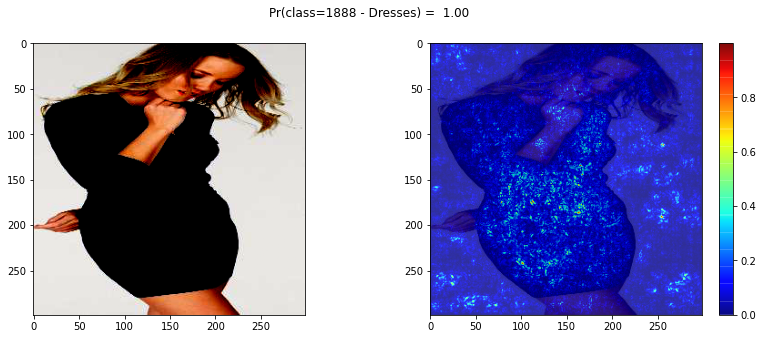

In [15]:
from vis.visualization import visualize_saliency

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x.reshape(299,299,3))

plot_map(grads)

## GRADCAM

In [16]:
from scipy.ndimage.interpolation import zoom

def visualize_cam_with_losses(input_tensor, losses, seed_input, penultimate_layer, grad_modifier=None):
    penultimate_output = penultimate_layer.output
    opt = Optimizer(input_tensor, losses, wrt_tensor=penultimate_output, norm_grads=False)
    _, grads, penultimate_output_value = opt.minimize(seed_input, max_iter=1, grad_modifier=grad_modifier, verbose=False)

    # For numerical stability. Very small grad values along with small penultimate_output_value can cause
    # w * penultimate_output_value to zero out, even for reasonable fp precision of float32.
    grads = grads / (np.max(grads) + K.epsilon())

    # Average pooling across all feature maps.
    # This captures the importance of feature map (channel) idx to the output.
    channel_idx = 1 if K.image_data_format() == 'channels_first' else -1
    other_axis = np.delete(np.arange(len(grads.shape)), channel_idx)
    weights = np.mean(grads, axis=tuple(other_axis))

    # Generate heatmap by computing weight * output over feature maps
    output_dims = utils.get_img_shape(penultimate_output_value)[2:]
    heatmap = np.zeros(shape=output_dims, dtype=K.floatx())
    for i, w in enumerate(weights):
        if channel_idx == -1:
            heatmap += w * penultimate_output_value[0, ..., i]
        else:
            heatmap += w * penultimate_output_value[0, i, ...]

    # ReLU thresholding to exclude pattern mismatch information (negative gradients).
    heatmap = np.maximum(heatmap, 0)

    # The penultimate feature map size is definitely smaller than input image.
    input_dims = 299, 299

    # Figure out the zoom factor.
    zoom_factor = [i / (j * 1.0) for i, j in iter(zip(input_dims, output_dims))]
    heatmap = zoom(heatmap, zoom_factor)
    return utils.normalize(heatmap)

In [17]:
def _find_penultimate_layer(model, layer_idx, penultimate_layer_idx):
    """Searches for the nearest penultimate `Conv` or `Pooling` layer.
    Args:
        model: The `keras.models.Model` instance.
        layer_idx: The layer index within `model.layers`.
        penultimate_layer_idx: The pre-layer to `layer_idx`. If set to None, the nearest penultimate
            `Conv` or `Pooling` layer is used.
    Returns:
        The penultimate layer.
    """
    if penultimate_layer_idx is None:
        for idx, layer in utils.reverse_enumerate(model.layers[:layer_idx - 1]):
            if isinstance(layer, Wrapper):
                layer = layer.layer
            if isinstance(layer, (_Conv, _Pooling1D, _Pooling2D, _Pooling3D)):
                penultimate_layer_idx = idx
                break

    if penultimate_layer_idx is None:
        raise ValueError('Unable to determine penultimate `Conv` or `Pooling` '
                         'layer for layer_idx: {}'.format(layer_idx))

    # Handle negative indexing otherwise the next check can fail.
    if layer_idx < 0:
        layer_idx = len(model.layers) + layer_idx
    if penultimate_layer_idx > layer_idx:
        raise ValueError('`penultimate_layer_idx` needs to be before `layer_idx`')

    return model.layers[penultimate_layer_idx]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


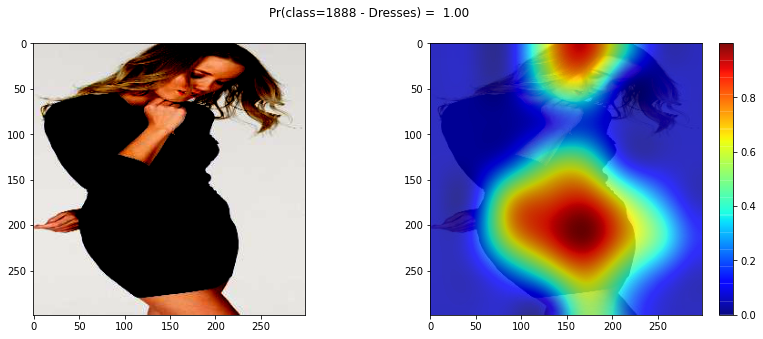

In [18]:
penultimate_layer = _find_penultimate_layer(model, layer_idx, None)

# `ActivationMaximization` outputs negative gradient values for increase in activations. Multiply with -1
# so that positive gradients indicate increase instead.
losses = [
    (ActivationMaximization(model.layers[layer_idx], class_idx), -1)
]

grads = visualize_cam_with_losses(model.input, losses, x, penultimate_layer, None)

plot_map(grads)